# **Chapter 4 - Optimization**

## Code Example - ***HallOfNN***

Link to video: https://www.youtube.com/watch?v=-aKZK4G9-V0

### **Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

### **Generate Data**

Assume true line is $y = b_1{\cdot}x + b_2$ where $b_1=3$ and $b_2 = 2$

Lets generate points sampled from this line and add some random noise: $y_n = b_1{\cdot}x + b_2 + N(0,3)$

$N$ - gaussian noise with $\mu=0$ and $\sigma^2=3$.

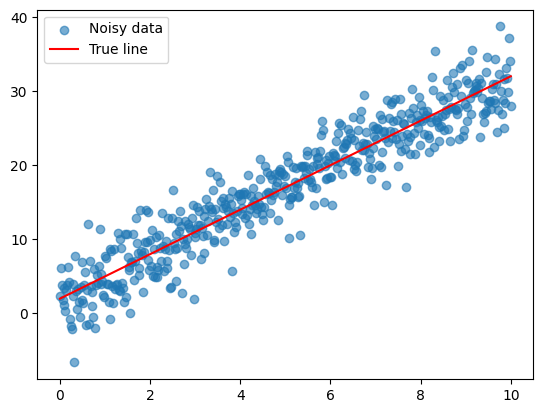

In [ ]:
torch.manual_seed(100)
N = 500
X = torch.linspace(0, 10, N).view(-1, 1)
y_true = 3 * X + 2
noise = torch.normal(0, 3, size=(N,1))
y_noisy = y_true + noise


plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
plt.legend()
plt.show()

### **Minimum Mean Squared Error Solution**

In [ ]:
X_mat = torch.cat([X, torch.ones_like(X)], dim=1)
b = torch.inverse(X_mat.t() @ X_mat) @ X_mat.t() @ y_noisy
print(f"Solution: \n\nB1: {b[0].item()}, \nB2: {b[1].item()}")

mse = torch.mean((y_noisy - b[0]*X - b[1])**2)
print(f"\n\nMSE: {mse.item()}")

Solution: 

B1: 2.99635648727417, 
B2: 2.1187455654144287


MSE: 8.507744789123535


### **Define Loss Function**

Our goal is to predict the parameters ${\hat{b_1}}$ and ${\hat{b_2}}$

We use the Mean Squared Error (MSE) loss function: $L = (y-y_{pred})^2 = (y-{\hat{b_1}}x-{\hat{b_2}})^2$

In [ ]:
def mse_loss(y, y_pred):
    return torch.mean((y - y_pred) ** 2)

## **Vanilla Gradient Descend**

Update Equation - $b_t = b_{t-1}-\mu{\nabla}L_{b}(y,y_{pred})$

where $b = (b_1, b_2)$.

The gradient w.r.t $b_1$:  

${\nabla}_{b_1}L(\cdot)$ = $\frac{-2}{N}\cdot\sum_{i}^{N}\left(x\cdot(y_i-y_{i}^{pred})\right)$

The gradient w.r.t $b_2$:  

${\nabla}_{b_2}L(\cdot)$  = $\frac{-2}{N}\cdot\sum_{i}^{N}\left(y_i-y_{i}^{pred}\right)$

In [ ]:
def compute_gradients(X, y, b1, b2):
    y_pred = b1 * X + b2
    error = y - y_pred
    db1 = (-2 / len(X)) * torch.sum(X * error)
    db2 = (-2 / len(X)) * torch.sum(error)
    return db1, db2


def train_full_gd(X, y, lr=0.01, epochs=100):
    # Start with random values for b1 and b2
    b1 = 5
    b2 = 5
    history = [(b1, b2, mse_loss(y, b1*X + b2).item())]


    for epoch in range(epochs): # Fix number of iterations
        indices = torch.randperm(len(X))[:] # - take all data
        X_batch = X[indices]
        y_batch = y[indices]
        db1, db2 = compute_gradients(X_batch, y_batch, b1, b2)
        b1 -= lr * db1 # update equation for b1
        b2 -= lr * db2 # update equation for b2


        loss = mse_loss(y, b1*X + b2).item()
        history.append((b1.item(), b2.item(), loss))


    return b1.item(), b2.item(), history

### **Optimize**

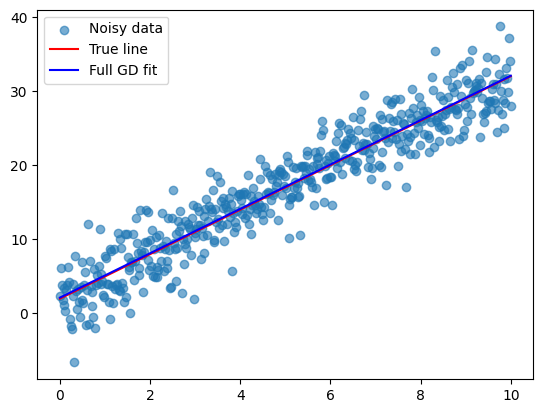



B1 = 2.993567705154419, B2 = 2.1372227668762207

MSE = 8.507830619812012


In [ ]:
b1_gd, b2_gd, hist_gd = train_full_gd(X, y_noisy, lr=0.01, epochs=1000)

plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
plt.plot(X.numpy(), (b1_gd*X+b2_gd).detach().numpy(), color="blue", label="Full GD fit")
plt.legend()
plt.show()

print(f"\n\nB1 = {b1_gd}, B2 = {b2_gd}")
print(f"\nMSE = {mse_loss(y_noisy, b1_gd*X + b2_gd).item()}")

### **Visualize Optimization Path**

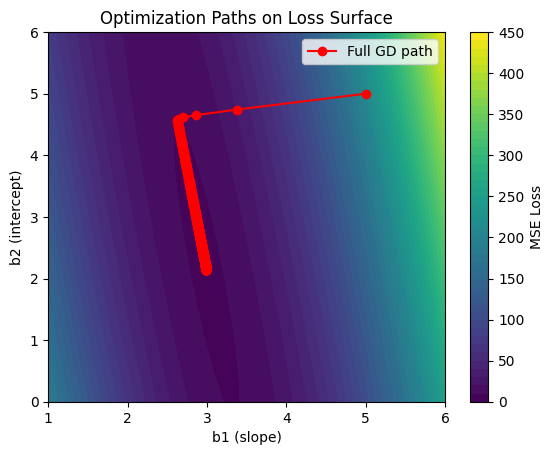

In [ ]:
b1_vals = np.linspace(1, 6, 100)
b2_vals = np.linspace(0, 6, 100)
B1, B2 = np.meshgrid(b1_vals, b2_vals)
Loss_surface = np.zeros_like(B1)

## Create Loss Surface
for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        y_pred = B1[i,j]*X + B2[i,j]
        Loss_surface[i,j] = mse_loss(y_noisy, y_pred).item()


# Extract optimization paths
path_gd = np.array([(b1, b2) for (b1,b2,_) in hist_gd])


# Plot contour with paths
plt.contourf(B1, B2, Loss_surface, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")
plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

### **What if we take a small value for the step size? Or a large value?**



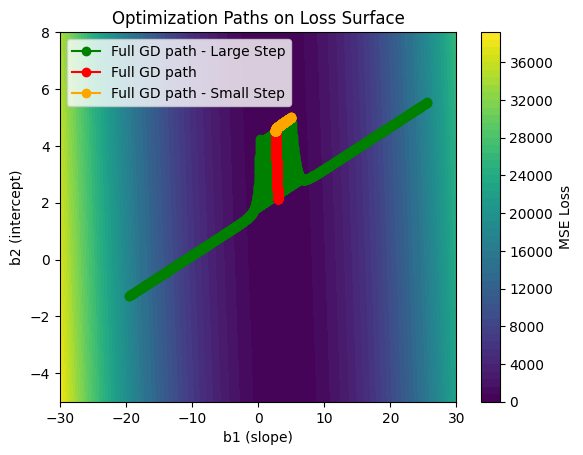

In [ ]:
b1_gd_biglr, b2_gd_biglr, hist_gd_biglr = train_full_gd(X, y_noisy, lr=0.02934, epochs=1000)
b1_gd_smalllr, b2_gd_smalllr, hist_gd_smalllr = train_full_gd(X, y_noisy, lr=0.0001, epochs=1000)

path_gd_biglr = np.array([(b1, b2) for (b1,b2,_) in hist_gd_biglr])
path_gd_smalllr = np.array([(b1, b2) for (b1,b2,_) in hist_gd_smalllr])

b1_vals = np.linspace(-30, 30, 100)
b2_vals = np.linspace(-5, 8, 100)
B1, B2 = np.meshgrid(b1_vals, b2_vals)
Loss_surface_2 = np.zeros_like(B1)

## Create Loss Surface
for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        y_pred = B1[i,j]*X + B2[i,j]
        Loss_surface_2[i,j] = mse_loss(y_noisy, y_pred).item()


# Plot contour with paths
plt.contourf(B1, B2, Loss_surface_2, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")

plt.plot(path_gd_biglr[:,0], path_gd_biglr[:,1], marker='o', color='green', label="Full GD path - Large Step")
plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.plot(path_gd_smalllr[:,0], path_gd_smalllr[:,1], marker='o', color='orange', label="Full GD path - Small Step")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

## **Stochastic Gradient Descend**


### Update Equation - $b_t = b_{t-1}-\mu{\frac{1}{B}}{\cdot}{\sum_{i=1}^{B}}{\nabla}L_{b}(y^i,y^i_{pred})$

### where $b = (b_1, b_2)$.


In [ ]:
def train_sgd(X, y, lr=0.01, epochs=50, batch_size=1):
    b1 = 5
    b2 = 5
    history = [(5,5,mse_loss(y, b1*X + b2).item())]


    for epoch in range(epochs):
        indices = torch.randperm(len(X))[:batch_size]
        X_batch = X[indices]
        y_batch = y[indices]
        y_pred = b1 * X_batch + b2
        error = y_batch - y_pred


        # gradients for a single sample
        db1 = -2 * X_batch * error
        db2 = -2 * error


        b1 -= lr * torch.sum(db1.reshape(-1) / batch_size)
        b2 -= lr * torch.sum(db2.reshape(-1) / batch_size)


        loss = mse_loss(y, b1*X + b2).item()
        history.append((b1.item(), b2.item(), loss))


    return b1.item(), b2.item(), history

### **Batch Size = 1**

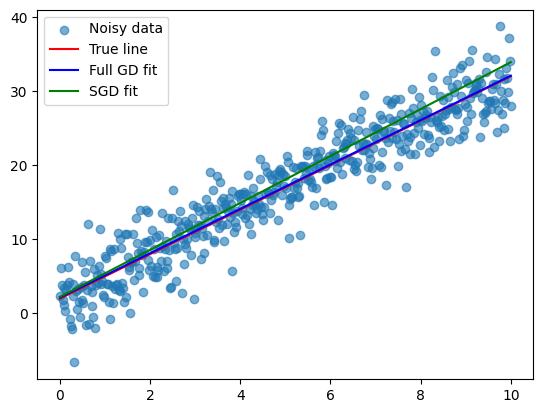

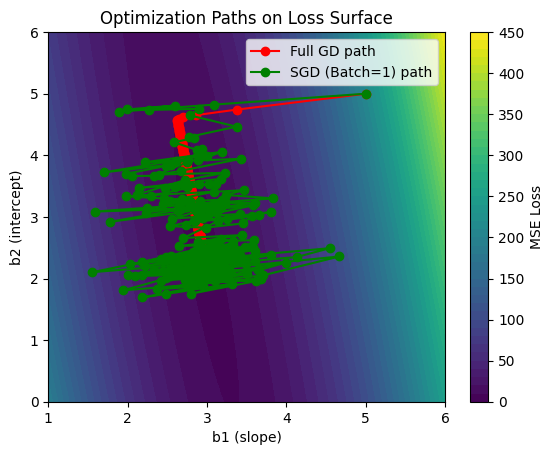



B1 = 3.165177345275879, B2 = 2.247476816177368

MSE = 9.692602157592773


In [ ]:
b1_sgd, b2_sgd, hist_sgd = train_sgd(X, y_noisy, lr=0.01, epochs=1000, batch_size=1)


plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
plt.plot(X.numpy(), (b1_gd*X+b2_gd).detach().numpy(), color="blue", label="Full GD fit")
plt.plot(X.numpy(), (b1_sgd*X+b2_sgd).detach().numpy(), color="green", label="SGD fit")
plt.legend()
plt.show()

path_sgd = np.array([(b1, b2) for (b1,b2,_) in hist_sgd])

# Plot contour with paths
b1_vals = np.linspace(1, 6, 100)
b2_vals = np.linspace(0, 6, 100)
B1, B2 = np.meshgrid(b1_vals, b2_vals)
Loss_surface_3 = np.zeros_like(B1)

## Create Loss Surface
for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        y_pred = B1[i,j]*X + B2[i,j]
        Loss_surface_3[i,j] = mse_loss(y_noisy, y_pred).item()



plt.contourf(B1, B2, Loss_surface_3, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")
plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.plot(path_sgd[::4,0], path_sgd[::4,1], marker='o', color='green', label="SGD (Batch=1) path")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

print(f"\n\nB1 = {b1_sgd}, B2 = {b2_sgd}")
print(f"\nMSE = {mse_loss(y_noisy, b1_sgd*X + b2_sgd).item()}")

### **Batch Size = 10**

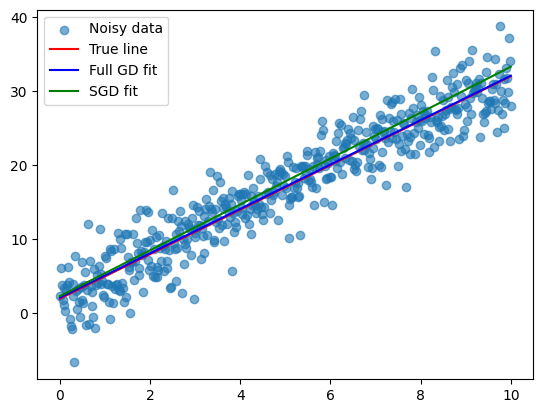

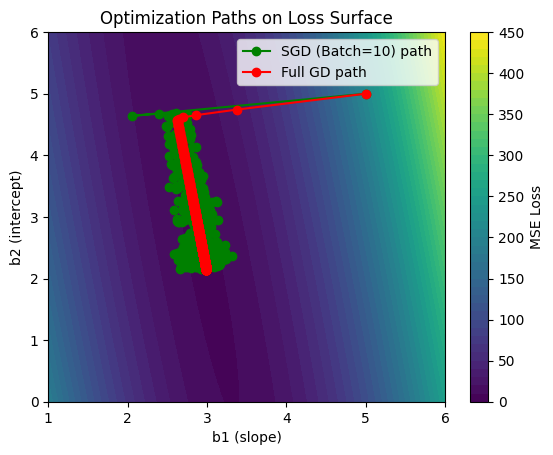



B1 = 3.094576120376587, B2 = 2.3386895656585693

MSE = 9.094036102294922


In [ ]:
b1_sgd, b2_sgd, hist_sgd = train_sgd(X, y_noisy, lr=0.01, epochs=1000, batch_size=10)

plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
plt.plot(X.numpy(), (b1_gd*X+b2_gd).detach().numpy(), color="blue", label="Full GD fit")
plt.plot(X.numpy(), (b1_sgd*X+b2_sgd).detach().numpy(), color="green", label="SGD fit")
plt.legend()
plt.show()

path_sgd = np.array([(b1, b2) for (b1,b2,_) in hist_sgd])

# Plot contour with paths
plt.contourf(B1, B2, Loss_surface_3, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")
plt.plot(path_sgd[:,0], path_sgd[:,1], marker='o', color='green', label="SGD (Batch=10) path")
plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

print(f"\n\nB1 = {b1_sgd}, B2 = {b2_sgd}")
print(f"\nMSE = {mse_loss(y_noisy, b1_sgd*X + b2_sgd).item()}")

## **Root Mean Squared Propagation (RMSProp)**

The RMSProp update equation:

$b_t = b_{t-1}-\frac{\mu}{\sqrt{s_{t+1}+\epsilon}}\left({\frac{1}{B}}{\cdot}{\sum_{i=1}^{B}}{\nabla}L_{b}(y^i,y^i_{pred})\right)$

where

$s_{t+1} = \beta\cdot s_{t} + (1-\beta)\cdot \nabla_{b}^{2} \left({\frac{1}{B}}{\cdot}{\sum_{i=1}^{B}}{\nabla}L_{b}(y^i,y^i_{pred})\right) $

In [ ]:
def train_rmsprop(X, y, lr=0.01, epochs=50, batch_size=1, beta=0.9, eps=1e-8):
    b1 = torch.tensor(5.0)
    b2 = torch.tensor(5.0)
    history = [(b1.item(), b2.item(), mse_loss(y, b1*X + b2).item())]

    # running average of squared gradients
    s_db1, s_db2 = 0.0, 0.0
    step_sizes = []

    for epoch in range(epochs):
        indices = torch.randperm(len(X))[:batch_size]
        X_batch = X[indices]
        y_batch = y[indices]
        y_pred = b1 * X_batch + b2
        error = y_batch - y_pred

        # gradients for batch
        db1 = -2 * torch.sum(X_batch * error) / batch_size
        db2 = -2 * torch.sum(error) / batch_size

        # update running averages (squared gradients)
        s_db1 = beta * s_db1 + (1 - beta) * db1**2
        s_db2 = beta * s_db2 + (1 - beta) * db2**2

        # parameter updates with RMSProp scaling
        b1 -= lr * db1 / torch.sqrt(s_db1 + eps)
        b2 -= lr * db2 / torch.sqrt(s_db2 + eps)

        # Effective step size (per parameter)
        eta_b1 = lr / (torch.sqrt(s_db1) + eps)
        eta_b2 = lr / (torch.sqrt(s_db2) + eps)
        step_sizes.append((eta_b1.item(), eta_b2.item()))

        # record loss
        loss = mse_loss(y, b1*X + b2).item()
        history.append((b1.item(), b2.item(), loss))

    return b1.item(), b2.item(), history, step_sizes


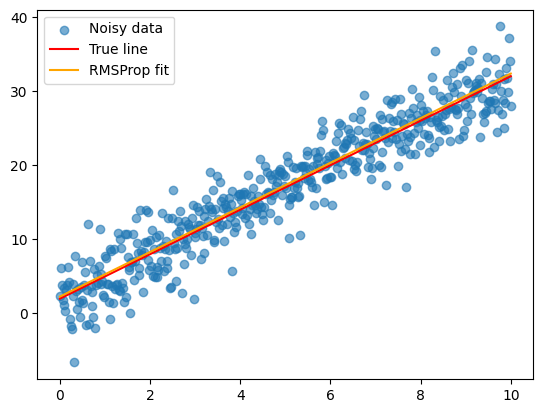

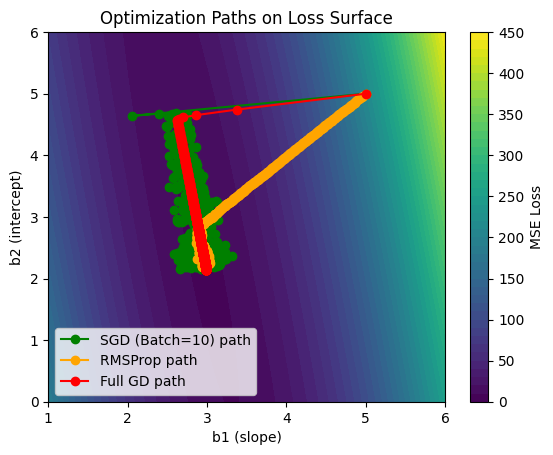



B1 = 3.008486032485962, B2 = 2.276376485824585

MSE = 8.556619644165039


In [ ]:
b1_rmsp, b2_rmsp, hist_rmsp, rmsp_steps = train_rmsprop(X, y_noisy, lr=0.01, epochs=1000, batch_size=10)

plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
# plt.plot(X.numpy(), (b1_gd*X+b2_gd).detach().numpy(), color="blue", label="Full GD fit")
# plt.plot(X.numpy(), (b1_sgd*X+b2_sgd).detach().numpy(), color="green", label="SGD fit")
plt.plot(X.numpy(), (b1_rmsp*X+b2_rmsp).detach().numpy(), color="orange", label="RMSProp fit")
plt.legend()
plt.show()

path_rmsp = np.array([(b1, b2) for (b1,b2,_) in hist_rmsp])

# Plot contour with paths
plt.contourf(B1, B2, Loss_surface_3, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")

plt.plot(path_sgd[:,0], path_sgd[:,1], marker='o', color='green', label="SGD (Batch=10) path")
plt.plot(path_rmsp[:,0], path_rmsp[:,1], marker='o', color='orange', label="RMSProp path")
plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

print(f"\n\nB1 = {b1_rmsp}, B2 = {b2_rmsp}")
print(f"\nMSE = {mse_loss(y_noisy, b1_rmsp*X + b2_rmsp).item()}")

## **ADAM**

In [ ]:
def train_adam(X, y, lr=0.01, epochs=50, batch_size=1,
               beta1=0.9, beta2=0.999, eps=1e-8, bias_correction=True):
    b1 = torch.tensor(5.0)
    b2 = torch.tensor(5.0)
    history = [(b1.item(), b2.item(), mse_loss(y, b1*X + b2).item())]

    # Initialize first and second moment estimates
    m_db1, m_db2 = 0.0, 0.0
    v_db1, v_db2 = 0.0, 0.0
    gradients = []
    step_sizes = []  # <-- store effective step sizes

    t = 0  # step counter

    for epoch in range(epochs):
        indices = torch.randperm(len(X))[:batch_size]
        X_batch = X[indices]
        y_batch = y[indices]
        y_pred = b1 * X_batch + b2
        error = y_batch - y_pred

        # gradients for batch
        db1 = -2 * torch.sum(X_batch * error) / batch_size
        db2 = -2 * torch.sum(error) / batch_size

        # Update biased first and second moments
        m_db1 = beta1 * m_db1 + (1 - beta1) * db1
        m_db2 = beta1 * m_db2 + (1 - beta1) * db2

        v_db1 = beta2 * v_db1 + (1 - beta2) * db1**2
        v_db2 = beta2 * v_db2 + (1 - beta2) * db2**2

        # Bias correction
        t += 1
        if bias_correction:
            m_db1_h = m_db1 / (1 - beta1**t)
            m_db2_h = m_db2 / (1 - beta1**t)
            v_db1_h = v_db1 / (1 - beta2**t)
            v_db2_h = v_db2 / (1 - beta2**t)
        else:
            m_db1_h = m_db1
            m_db2_h = m_db2
            v_db1_h = v_db1
            v_db2_h = v_db2

        gradients.append(((m_db1_h, m_db2_h),(v_db1_h, v_db2_h)))

        # Effective step size (per parameter)
        eta_b1 = lr / (torch.sqrt(v_db1_h) + eps)
        eta_b2 = lr / (torch.sqrt(v_db2_h) + eps)
        step_sizes.append((eta_b1.item(), eta_b2.item()))

        # Update parameters
        b1 = b1 - eta_b1 * m_db1_h
        b2 = b2 - eta_b2 * m_db2_h

        # record loss
        loss = mse_loss(y, b1*X + b2).item()
        history.append((b1.item(), b2.item(), loss))

    return b1.item(), b2.item(), history, gradients, step_sizes


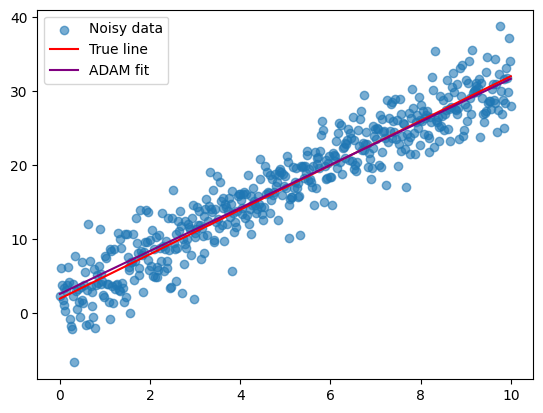

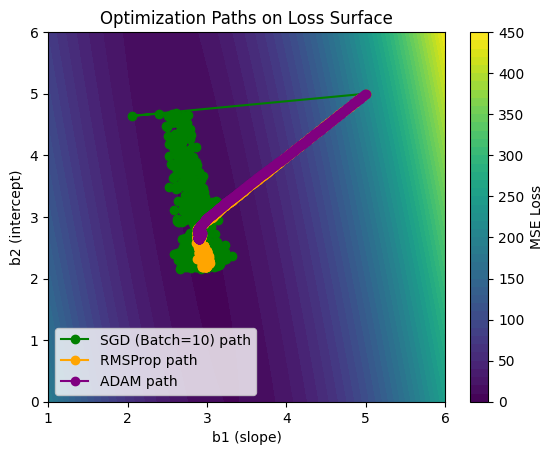



B1 = 2.90155029296875, B2 = 2.6420295238494873

MSE = 8.585372924804688


In [ ]:
b1_adam, b2_adam, hist_adam, gradients, adam_bias_step_sizes = train_adam(X, y_noisy, lr=0.01, epochs=1000, batch_size=10, bias_correction=True)

plt.scatter(X.numpy(), y_noisy.numpy(), alpha=0.6, label="Noisy data")
plt.plot(X.numpy(), y_true.numpy(), color="red", label="True line")
plt.plot(X.numpy(), (b1_adam*X+b2_adam).detach().numpy(), color="purple", label="ADAM fit")
plt.legend()
plt.show()

path_adam = np.array([(b1, b2) for (b1,b2,_) in hist_adam])

# Plot contour with paths
plt.contourf(B1, B2, Loss_surface_3, levels=50, cmap='viridis')
plt.colorbar(label="MSE Loss")

plt.plot(path_sgd[:,0], path_sgd[:,1], marker='o', color='green', label="SGD (Batch=10) path")
plt.plot(path_rmsp[:,0], path_rmsp[:,1], marker='o', color='orange', label="RMSProp path")
plt.plot(path_adam[:,0], path_adam[:,1], marker='o', color='purple', label="ADAM path")
# plt.plot(path_gd[:,0], path_gd[:,1], marker='o', color='red', label="Full GD path")
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (intercept)")
plt.legend()
plt.title("Optimization Paths on Loss Surface")
plt.show()

print(f"\n\nB1 = {b1_adam}, B2 = {b2_adam}")
print(f"\nMSE = {mse_loss(y_noisy, b1_adam*X + b2_adam).item()}")

## **Addition**

Why ADAM perform less better than RMSProp?

Lets look on the effective step sizes values:




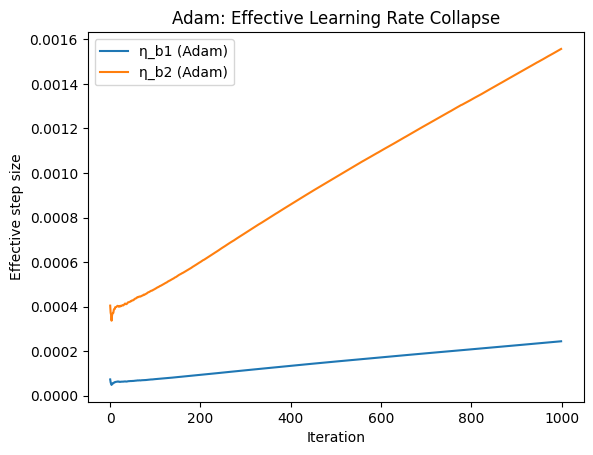

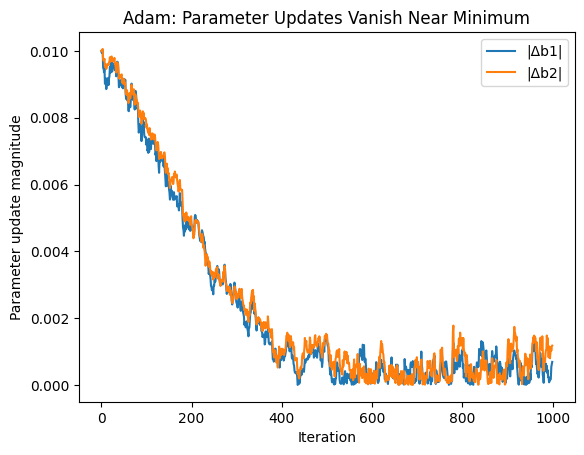

In [ ]:
# ============================
# ADAM DIAGNOSTICS (KEY DEMO)
# ============================

step_sizes = np.array(adam_bias_step_sizes)   # shape: [T, 2]
hist = np.array(hist_adam)

# Parameter update magnitudes
delta_b1 = np.abs(np.diff(hist[:, 0]))
delta_b2 = np.abs(np.diff(hist[:, 1]))

# Plot effective learning rates
plt.figure()
plt.plot(step_sizes[:, 0], label="η_b1 (Adam)")
plt.plot(step_sizes[:, 1], label="η_b2 (Adam)")
plt.yscale("linear")
plt.xlabel("Iteration")
plt.ylabel("Effective step size")
plt.title("Adam: Effective Learning Rate Collapse")
plt.legend()
plt.show()

# Plot actual parameter movement
plt.figure()
plt.plot(delta_b1, label="|Δb1|")
plt.plot(delta_b2, label="|Δb2|")
plt.yscale("linear")
plt.xlabel("Iteration")
plt.ylabel("Parameter update magnitude")
plt.title("Adam: Parameter Updates Vanish Near Minimum")
plt.legend()
plt.show()




### **Conclusion:**

In this linear regression problem, **ADAM** performs worse than **RMSProp** not because its learning rate becomes too small, but because its actual parameter updates vanish near the minimum.

More precisely:


As training progresses, the effective learning rate:


$\eta_t = \frac{lr}{\sqrt{u_t+\epsilon}}$


may increase, not decrease.

However, Adam multiplies this by a momentum term

$m_t = EMA(g_t)$


which cancels out near the minimum due to gradient sign oscillations.

The product

$\Delta\beta=\eta \cdot m_t$


therefore goes to zero, even though the minimum has not been fully reached.



### **So - When ADAM is Better?**

Adam is better when the problem is noisy, high-dimensional, badly scaled, or non-stationary — and exact convergence is not the goal.